# Force Displacement Prediction using LSTM

This notebook demonstrates how to build and train an LSTM model to predict force vs displacement data given FEA inputs.

## Import Libraries

First, we import the necessary libraries for data manipulation, model building, training, and evaluation.

In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shutil
import os

# Clear the GPU memory
torch.cuda.empty_cache()

## Load and Preprocess Data

We load the FEA input data from `InputDataWood.csv` and the corresponding force vs displacement data from the `Results` folder. We apply min-max scaling to all data and split it into training, validation, and test sets.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load InputNewData.csv
input_data = pd.read_csv('InputDataWood.csv', header=None, names=['Ef','Em','G12', 'epsmi', 'epsfi', 'epsms','epsfs'])

# Initialize lists to hold the data
fea_inputs = []
displacement_data = []
force_data = []

# Iterate through the rows of InputNewData.csv
for idx, row in input_data.iterrows():
    file_name = f'Results90/LD_Data{idx}.csv'
    if os.path.exists(file_name):
        # Load the corresponding force displacement CSV file
        result_data = pd.read_csv(file_name, header=None)
        displacement = result_data.iloc[0].values.astype(float)
        force = result_data.iloc[1].values.astype(float)

        displacement = np.multiply(displacement,1.8)
        # highest thickness measured in experiments 5.3mm
        force = np.multiply(force, 5.3/3.8)
        
        # Crop the data after 2mm displacement
        mask = displacement <= 2.5
        displacement = displacement[mask]
        force = force[mask]

        # Adjust displacement to increase in increments of 0.05mm
        new_displacement = np.arange(0, 2.55, 0.05)  # Generate displacement values from 0 to 2mm in 0.05mm increments
        new_force = np.interp(new_displacement, displacement, force)  # Interpolate force values to match new displacement
 
        # Append the data to the lists
        #fea_inputs.append(row.values.astype(float))
        # Append only Em, G12, epsmi, and epsms to the fea_inputs list
        fea_inputs.append(row[['Ef', 'epsfi', 'epsfs']].values.astype(float))
        
        displacement_data.append(new_displacement)
        force_data.append(new_force)
        #displacement_data.append(displacement)
        #force_data.append(force)

# Convert lists to numpy arrays
fea_inputs = np.array(fea_inputs)
displacement_data = np.array(displacement_data)
force_data = np.array(force_data)

# Apply min-max scaling to EM, SDI, and FE
scaler = MinMaxScaler()
fea_inputs_scaled = scaler.fit_transform(fea_inputs)

# Apply min-max scaling to force data
force_scaler = MinMaxScaler(feature_range=(0, 10))
force_data_scaled = force_scaler.fit_transform(force_data.reshape(-1, 1)).reshape(force_data.shape)

# Prepare input data by combining scaled EM, SDI, FE with displacement
def prepare_input_data(fea_inputs_scaled, displacement_data):
    batch_size = fea_inputs_scaled.shape[0]
    sequence_length = displacement_data.shape[1]
    fea_inputs_repeated = np.repeat(fea_inputs_scaled[:, np.newaxis, :], sequence_length, axis=1)
    input_data = np.concatenate((fea_inputs_repeated, displacement_data[:, :, np.newaxis]), axis=2)
    return input_data

# Prepare input and output data
input_data = prepare_input_data(fea_inputs_scaled, displacement_data)
output_data = force_data_scaled[:, :, np.newaxis]  # Scaled force data as output

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(input_data, output_data, test_size=100, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

## Define LSTM Model

We define an LSTM model with the specified architecture. The model consists of an LSTM layer followed by a fully connected layer.

In [45]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out)
        return out

## Set Hyperparameters

We set the hyperparameters for the model, including the input size, hidden size, number of layers, output size, number of epochs, batch size, and learning rate.

In [46]:
# Set hyperparameters
input_size = 4 # EM, SDI, FE, and displacement
hidden_size = 100
num_layers = 3
output_size = 1  # Force
num_epochs = 3000
batch_size = 64
learning_rate = 0.001
dropout = 0.2  # Dropout rate

# Initialize model, loss function, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

## Prepare Data Loaders

We prepare data loaders for the training and validation sets to facilitate batch processing during training.

In [47]:
# Prepare data loaders
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

## Training Loop

We define the training loop, which includes training and validation steps for each epoch. We log the training and validation loss to TensorBoard.

In [ ]:
import shutil
import os
import time
from torch.utils.tensorboard import SummaryWriter

torch.cuda.empty_cache()

# Define the log directory
log_dir = 'Wood/Calibration90/LSTM_Exp_04/runs'

# Delete the existing log directory if it exists
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

# Create a new SummaryWriter
writer = SummaryWriter(log_dir=log_dir)

# Training loop with learning rate scheduler and early stopping
best_val_loss = float('inf')
early_stop_patience = 20
early_stop_counter = 0

# Track total training time
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    total_elapsed_time = epoch_end_time - start_time

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch Time: {epoch_duration:.2f}s, Total Time: {total_elapsed_time:.2f}s')
    
    scheduler.step(val_loss)

    # Save the number of completed epochs
    with open('Wood/Calibration90/LSTM_Exp_04/completed_epochs.txt', 'w') as f:
        f.write(str(epoch + 1))
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'Wood/Calibration90/LSTM_Exp_04/best_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered")
            break

# Load the best model
model.load_state_dict(torch.load('Wood/Calibration90/LSTM_Exp_04/best_model.pth'))

# Close TensorBoard writer
writer.close()

## Evaluation

We evaluate the model on the test set using MAE, RMSE, MAPE, and R² metrics. We also visualize the training and validation loss curves, predicted vs actual force displacement curves, and the error distribution.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the best model
model.load_state_dict(torch.load('Wood/Calibration90/LSTM_Exp_04/best_model.pth'))

# Evaluation
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

#print(X_test_tensor)

with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
y_pred_scaled = y_pred_tensor.cpu().numpy()

# Inverse transform the predictions and true values to the original scale
y_pred = force_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(y_pred_scaled.shape)
y_test_original = force_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_original.reshape(-1, 1), y_pred.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test_original.reshape(-1, 1), y_pred.reshape(-1, 1)))
mape = np.mean(np.abs((y_test_original.reshape(-1, 1) - y_pred.reshape(-1, 1)) / y_test_original.reshape(-1, 1))) * 100
r2 = r2_score(y_test_original.reshape(-1, 1), y_pred.reshape(-1, 1))

print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%, R²: {r2:.4f}')

# Plot predicted vs actual force displacement curves
from matplotlib.ticker import StrMethodFormatter
plt.rcParams.update({'font.size': 18})
fig = plt.subplots(figsize =(12, 8))
displacement_sequence = np.concatenate(([0], np.linspace(0, 2.5, 50)))  # Example displacement sequence

for i in range(len(y_pred)):  # Plot all test samples
    plt.plot(displacement_sequence[:len(y_test_original[i, :, 0])], np.divide(y_test_original[i, :, 0],1000), marker='o', markersize = 12, markevery=4, label='FE simulation', color='red', linewidth=3)
    plt.plot(displacement_sequence[:len(y_pred[i, :, 0])], np.divide(y_pred[i, :, 0],1000), label='ML prediction', linestyle='--', color='blue', linewidth=5)
    plt.xlim(0, 2.6)
    plt.ylim(0, 1.4)
    plt.xlabel('Displacement (mm)')
    plt.ylabel('Force (kN)')
    plt.legend(loc="upper left",ncol = 1)
    # Include the EM, SDI, and FE values in the title, ensuring that the values are unscaled
    fea_inputs_values = scaler.inverse_transform(X_test[i, 0, :3].reshape(1, -1))[0]
    #plt.title(f'EM: {fea_inputs_values[0]:,.0f} MPa, G12: {fea_inputs_values[1]:,.0f} MPa, INIT: {fea_inputs_values[2]:.4f} mm/mm, SAT: {fea_inputs_values[3]:.4f} mm/mm')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('LDML'+str(i)+'.png')
    plt.show()



import pickle
with open("S:\Hannes\RobML\SEJ446-main\Wood\Calibration90\Error45","rb") as file_handle:
    error45 = pickle.load(file_handle)

# Plot error distribution
errors = y_test_original - y_pred
plt.figure()
plt.hist(errors.flatten(), bins=50, color='blue', label='LSTM 0')
plt.hist(error45, bins=50, color='green', alpha=0.8, label='LSTM 45')
plt.xlabel('Error (N)')
plt.ylabel('Frequency')
plt.xlim(-100, 100)
plt.legend(loc="upper left",ncol = 1)
plt.tight_layout()
plt.savefig('MLError4590.png')
plt.show()

# Close TensorBoard writer
writer.close()

[[0.52014127 0.2570506  0.22812191]]
34    1.028548
35    1.051716
36    1.072417
37    1.086566
38    1.082962
39    1.079595
40    1.100841
41    1.116522
42    1.122572
43    1.122298
44    1.117138
45    1.120374
46    1.122816
47    1.132059
48    1.122210
Name: Mean Force (KN), dtype: float64
The MLE is:  [0.43086836 0.81402144 0.65435558]
The predicted load curve at the MLE point is:  [[[0.01497281]
  [0.041513  ]
  [0.06880283]
  [0.09807358]
  [0.12951508]
  [0.16257071]
  [0.19647597]
  [0.2305848 ]
  [0.26447678]
  [0.29794505]
  [0.33094233]
  [0.3635246 ]
  [0.3958041 ]
  [0.42791614]
  [0.459994  ]
  [0.4921515 ]
  [0.52447087]
  [0.5569961 ]
  [0.5897313 ]
  [0.62264425]
  [0.65567565]
  [0.6887511 ]
  [0.72179204]
  [0.75473106]
  [0.78751945]
  [0.82013524]
  [0.852587  ]
  [0.8849126 ]
  [0.9171762 ]
  [0.9494603 ]
  [0.9818556 ]
  [1.0144477 ]
  [1.0473034 ]
  [1.0804546 ]
  [1.1138833 ]
  [1.1475085 ]
  [1.1811785 ]
  [1.214682  ]
  [1.2477946 ]
  [1.280375  ]
  [1.

 69%|██████▉   | 13800/20000 [43:40<19:37,  5.27it/s] 


Wood/total time 2620.8714022636414


Inference data with groups:
	> posterior
	> sample_stats

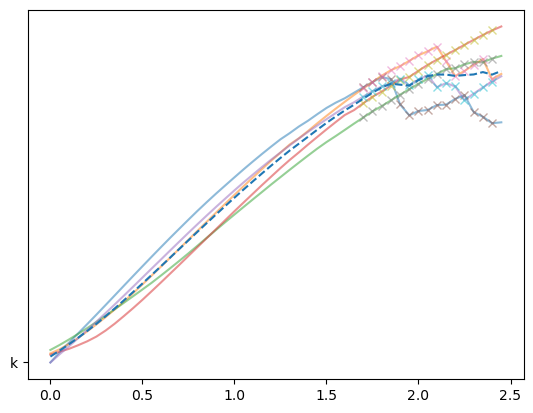

In [50]:
import os
#import h5py
import numpy as np
from tensorflow.python import keras
import tensorflow as tf
import math
from scipy.optimize import minimize
from scipy.stats import norm
import emcee
import arviz as ar
import time
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.interpolate import interp1d
import joblib
from numpy.linalg import cholesky, det, lstsq
from sklearn.covariance import empirical_covariance
import csv
import scipy.linalg.lapack as lapack

np.random.seed(42)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pickle
with open("Mean_Force.pkl","rb") as file_handle:
    y_L_mean = pickle.load(file_handle)



from scipy.interpolate import interp1d
import joblib

# Load the best model
model.load_state_dict(torch.load('Wood/Calibration90/LSTM_Exp_04/best_model.pth'))


nominal_values = np.array([14000, 0.0059, 0.084])
nominal_values_scaled = scaler.transform(nominal_values.reshape(1, -1))
print(nominal_values_scaled)

# Define a function that takes theta and maps to predicted S_OHT
# #𝑓(𝑥₁, 𝑥₂) = 𝑏₀ + 𝑏₁𝑥₁ + 𝑏₂𝑥₂ + 𝑏₃𝑥₁² + 𝑏₄𝑥₁𝑥₂ + 𝑏₅𝑥₂²
# This will be called the forward model function
def forward_model(theta):
    #loads = clf2.predict(theta.reshape(-1, 3))
    model.eval()
    Xtensor = torch.tensor([], dtype=torch.float32)
    for di in range(51):  # Add 3 new rows
        value = di * 0.05  # Calculate the current value
        new_row = torch.tensor([[theta[0], theta[1], theta[2], value]], dtype=torch.float32) 
        Xtensor = torch.cat((Xtensor, new_row), dim=0) 
    batch_size = 1  # Example batch size
    sequence_length = Xtensor.size(0)  # Number of rows in Xtensor
    feature_size = Xtensor.size(1)  # Number of columns in Xtensor
    Xtensor_3D = Xtensor.view(batch_size, sequence_length, feature_size)  # Reshape to 3D tensor
    y_pred_tensor = model(Xtensor_3D)
    y_pred_scaled = y_pred_tensor.detach().cpu().numpy()
    y_pred = force_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(y_pred_scaled.shape)

    return np.divide(y_pred,1000)



def log_prior(theta, mean=[nominal_values_scaled[0][0], nominal_values_scaled[0][1], nominal_values_scaled[0][2]], cov=np.diag([0.1, 0.1, 0.1])):

    if mean is None:
        mean = [0.5, 0.5, 0.5]  # Default mean vector for [E1, G12, e1_i, e1_s]
    if cov is None:
        cov = np.diag([0.1, 0.1, 0.1])  # Default covariance matrix (diagonal)

    # Ensure all parameters are within the range [0, 1]
    if not np.all((0.05 <= theta) & (theta <= 0.85)):
        return -np.inf  # Return -inf if any parameter is out of bounds

    # Check if the covariance matrix is positive definite
    if not np.all(np.linalg.eigvals(cov) > 0):
        raise ValueError("Covariance matrix must be positive definite.")

    # Compute the log-prior using the multivariate normal distribution
    log_prior_value = multivariate_normal.logpdf(theta, mean=mean, cov=cov)

    return log_prior_value

from scipy.stats import multivariate_normal

file_paths = [
    r"Exp_CT90_1.csv",
    r"Exp_CT90_2.csv",
    r"Exp_CT90_3.csv",
    r"Exp_CT90_4.csv",
    r"Exp_CT90_5.csv",
]

# Initialize a list to store dataframes
dataframes = []

# Load all CSV files into dataframes
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Combine all dataframes by aligning on "Displacement (mm)"
combined_df = pd.concat(dataframes, axis=1, join="inner")

# Extract displacement and force columns
displacement = combined_df.iloc[:, 0]  # Displacement is the first column
forces = combined_df.iloc[:, 1::2]  # Extract every second column (force columns)
# Plot individual forces
Klist = []
for i, column in enumerate(forces.columns):
    if i == 0:  # Add the label only for the first curve
        plt.plot(displacement, forces[column], alpha=0.5)
        plt.plot(displacement[34:-1][::1], forces[column][34:-1][::1],'x', alpha=0.5)
        Klist.append(forces[column][34:-1][::1].values.tolist())
plt.plot(y_L_mean["Displacement (mm)"], np.divide(y_L_mean["Mean Force (KN)"],1), '--')
print(y_L_mean[34:-1][::1]["Mean Force (KN)"])


#def log_likelihood(theta, mu_y=y_L_mean[15:20][::8]+y_L_mean[-15:-1][::2], K = np.cov(np.array(ExtractList2(y_L_cut[:-2],15,20,-15,-1)).T)):
def log_likelihood(theta, mu_y=y_L_mean[34:-1][::1]["Mean Force (KN)"].values.tolist(), K = np.cov(np.array(Klist[0]).T)):
    # accounting for thickness change (3.6 and 4 mm)
#def log_likelihood(theta, coef, mu_y=8677.3, sigma_y=552.5):
    Loads_hat = forward_model(theta)
    Loads_hat2 = np.divide(Loads_hat[0].T,1)
    #diffY = np.subtract(Loads_hat[0:63],mu_y)
    #print(Loads_hat2[0][25:-1][::6])
    diffY = np.subtract(Loads_hat2[0][34:-2][::1],mu_y)
    diffY2 = diffY.reshape(15, 1)  # Reshape theta to (4, 1)
    #print(diffY2)
    epsilon = 1e-6  # Small positive value
    while not np.all(np.linalg.eigvals(K) > 0):
        print("K is not positive definite. Adding regularization...")
        K += np.eye(K.shape[0]) * epsilon
    Chol = np.linalg.cholesky(K)
    detK = np.prod(np.diag(Chol))
    L_inv_y_minus_mu, _ = lapack.dtrtrs(Chol, diffY2, lower=True)
    L_mahalanobis_squared = L_inv_y_minus_mu.T @ L_inv_y_minus_mu
    #ytest = gaussian_process.predict(np.array(values).reshape(-1, 63))
    return (-len(mu_y)*np.log(2*math.pi)-len(mu_y)*np.log(detK)-0.5*L_mahalanobis_squared)


# DEFINE LOG POSTERIOR
# function for the log-posterior
def log_post(theta):
    lprior = log_prior(theta)
    if not np.isfinite(lprior):
        return -np.inf
    else:
        return lprior + log_likelihood(theta)

# PERFORM MLE TO INITIALIZE MCMC CHAINS
nll = lambda theta: -log_likelihood(theta) # lambda function for negative loglikelihood

E1 = np.random.uniform(0.12, 0.95,1)
e1_i = np.random.uniform(0.12, 0.85,1)
e1_s = np.random.uniform(0.12, 0.85,1)
initial = np.array([E1, e1_i, e1_s])
initial = np.reshape(initial, (-1,3))

bounds = ((0.05, 0.85), (0.05, 0.85), (0.05, 0.85))
soln = minimize(nll, initial[0])

print("The MLE is: ", soln.x)
print("The predicted load curve at the MLE point is: ", forward_model(soln.x)[0:63])

# MCMC SAMPLING
nwalkers = 50 # number of walkers in the ensemble
ndim = 3 # nmumber of free variables

max_n = 20000 # maximum number of iterations
check = 200 # check convergence every check samples
auto_corr_multipier = 100 # chain length is greater than tau times this
delta_auto_corr = 0.01 # upper lim on percent change of tau

# inital points
initial_pnts = soln.x + 1e-4*np.random.randn(nwalkers, ndim)

# constuct emcee sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)

# We will run emcee in a way that automatically checks for convergence
# Following code modified from https://emcee.readthedocs.io/en/stable/tutorials/monitor/
# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
start = time.time()
for sample in sampler.sample(initial_pnts, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % check:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    # check if number of iterations is greater than the autocorrelation time
    converged = np.all(tau * auto_corr_multipier < sampler.iteration)
    # check if autocorrelation time is smaller than 
    converged &= np.all(np.abs(old_tau - tau) / tau < delta_auto_corr)
    if converged:
        break
    old_tau = tau
end = time.time()

elapsed = end - start 
print('Wood/total time', elapsed)

with open('Wood/timing_before2193.txt', 'w') as f:
    f.write('start time'+str(start))
    f.write('end time '+str(end))
    f.write('total time '+str(elapsed))


# Save the data to an arviz file
var_names = ["E1","e1_i", "e1_s"]
idata1 = ar.from_emcee(sampler, var_names=var_names)
idata1.to_netcdf('Wood/20240224_posteriorSamples_after4')

idata1.sel(draw=slice(100, None))

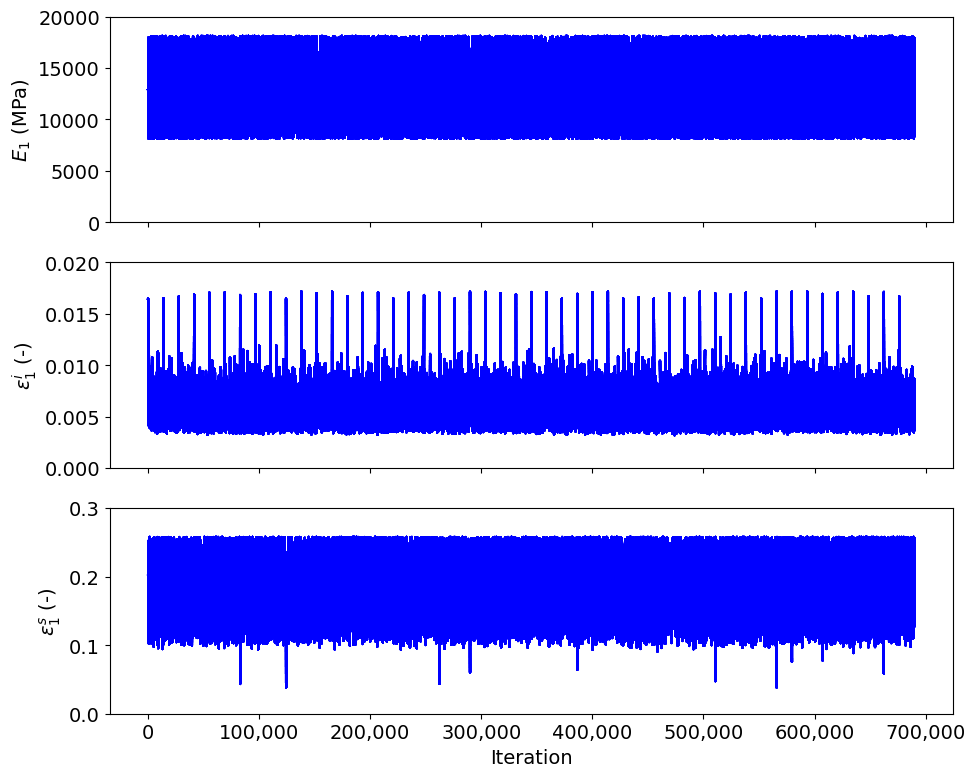

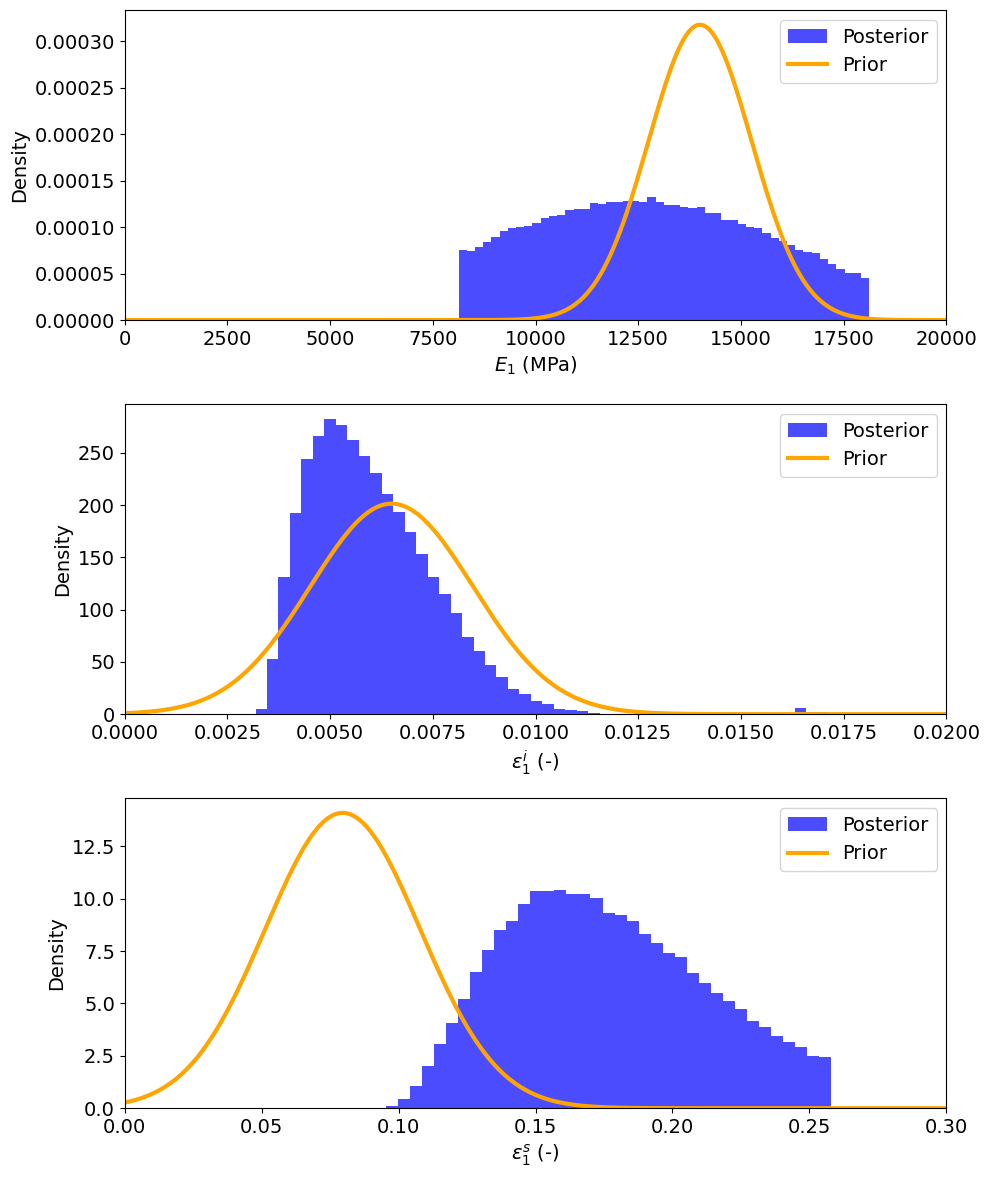

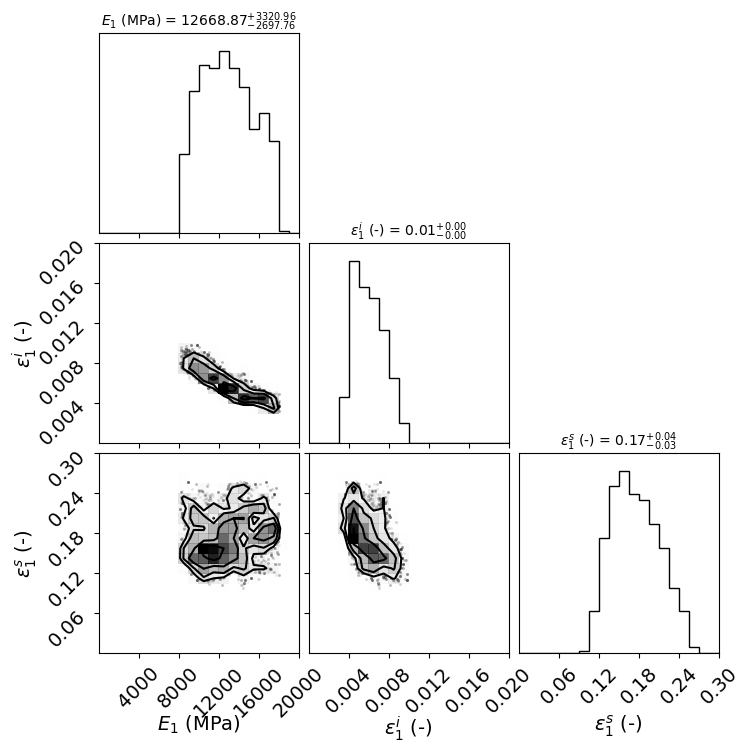

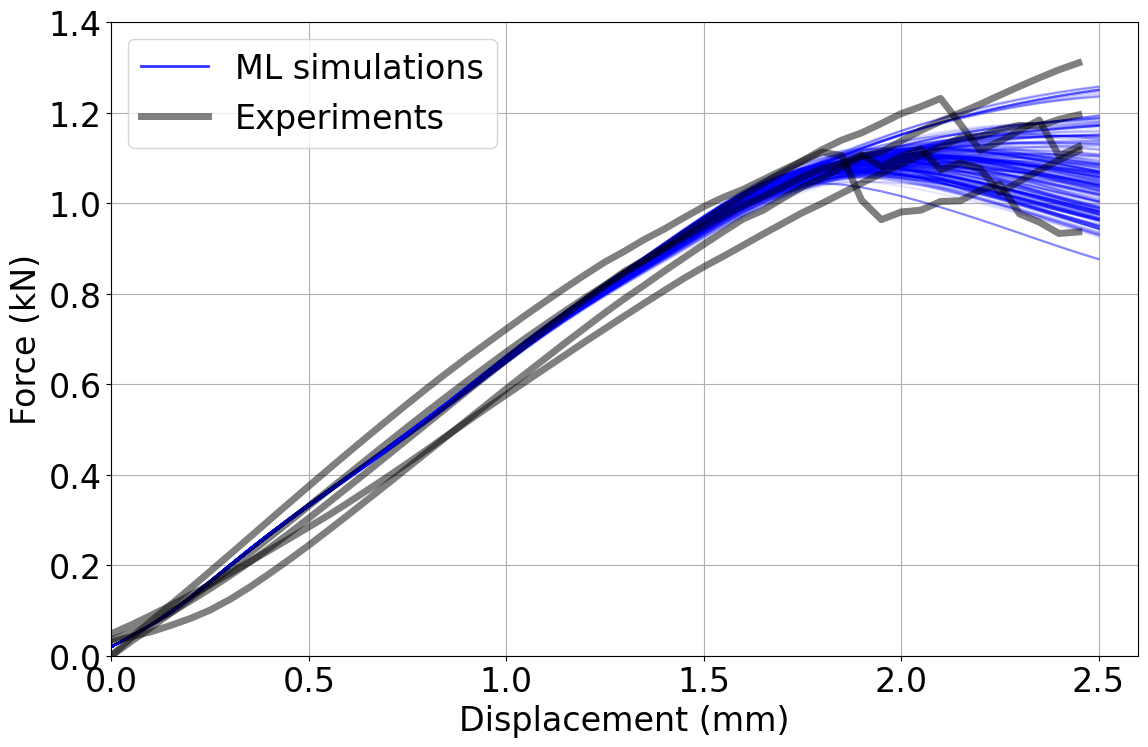

In [77]:
# Save the data to an arviz file
var_names = ["E1","e1_i", "e1_s"]
idata1 = ar.from_emcee(sampler, var_names=var_names)
idata1.to_netcdf('Wood/20240224_posteriorSamples_after4')

idata1.sel(draw=slice(100, None))

import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 14}) # Sets a global default font size

idata = ar.from_emcee(sampler, var_names=var_names)
# Plot MCMC chains for each parameter
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
param_names = ["E1","e1_i", "e1_s"]

# Extract all chains for all parameters
scaled_chains = []
for param in param_names:
    # Combine all walkers and iterations for the parameter
    param_chain = idata.posterior[param].values.reshape(-1)
    scaled_chains.append(param_chain)

# Stack all parameter chains into a single array for inverse transformation
scaled_chains = np.stack(scaled_chains, axis=1)  # Shape: (n_samples, 4)

# Scale the values back to their original range
original_chains = scaler.inverse_transform(scaled_chains)  # Shape: (n_samples, 4)

# Plot the original (unscaled) chains for each parameter
for i, param in enumerate(param_names):
    for walker in range(nwalkers):
        # Extract the chain for the current parameter and walker
        original_chain = original_chains[:, i]
        axes[i].plot(original_chain, alpha=0.5, color='blue')

    # Set labels and titles
    if param == "E1":
        axes[i].set_ylabel("$E_1$ (MPa)")
        axes[i].set_ylim(0,20000)
    if param == "e1_i":
        axes[i].set_ylabel("$\epsilon_1^i$ (-)")
        axes[i].set_ylim(0,0.02)
    if param == "e1_s":
        axes[i].set_ylabel("$\epsilon_1^s$ (-)")
        axes[i].set_ylim(0,0.3)
    #axes[i].set_title(f"MCMC Chains for {param} (Original Scale)")

axes[-1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
axes[-1].set_xlabel("Iteration")
plt.tight_layout()
plt.savefig('MCMCchains90.png')
plt.show()


prior_samples = {
    "E1": np.random.normal(nominal_values_scaled[0][0], 0.1, 2000),  # Uniform prior for E1
    "e1_i": np.random.normal(nominal_values_scaled[0][1], 0.1, 2000),  # Gaussian prior for e1_i
    "e1_s": np.random.normal(nominal_values_scaled[0][2], 0.1, 2000),  # Uniform prior for e1_s
}

# Plot posterior distributions with prior overlay
#fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=False)
param_names = ["E1", "e1_i", "e1_s"]
axis_limits = {"E1": (0, 1), "e1_i": (0, 1), "e1_s": (0, 1)}  # Adjust axis limits


# Extract and transform posterior samples to original units
posterior_samples_original = {}
for param in param_names:
    samples = idata.posterior[param].values.reshape(-1, 1)
    idx = param_names.index(param)
    temp = np.zeros((samples.shape[0], len(param_names)))
    temp[:, idx] = samples[:, 0]
    posterior_samples_original[param] = scaler.inverse_transform(temp)[:, idx]


prior_samples_original = {}
for param in param_names:
    reshaped = prior_samples[param].reshape(-1, 1)
    idx = param_names.index(param)
    temp = np.zeros((reshaped.shape[0], len(param_names)))
    temp[:, idx] = reshaped[:, 0]
    prior_samples_original[param] = scaler.inverse_transform(temp)[:, idx]


# Plot posterior distributions in original units
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=False)
axis_limits = {"E1": (0, 20000), "e1_i": (0, 0.02), "e1_s": (0, 0.3)}

for i, param in enumerate(param_names):
    data = prior_samples_original[param]
    mu, std = np.mean(data), np.std(data)
    x = np.linspace(axis_limits[param][0],axis_limits[param][1],500)
    y = norm.pdf(x, mu, std)
    axes[i].hist(posterior_samples_original[param], bins=50, density=True, alpha=0.7, label="Posterior", color="blue")
    axes[i].plot(x,y, label="Prior", color="orange", linewidth=3)
    #axes[i].hist(prior_samples_original[param], bins=50, density=True, alpha=0.5, label="Prior", color="orange")
    axes[i].set_xlim(axis_limits[param])
    #axes[i].set_title(f"Posterior for {param} (Original Units)")
    axes[i].set_ylabel("Density")
    if param == "E1":
        axes[i].set_xlabel("$E_1$ (MPa)")
    if param == "e1_i":
        axes[i].set_xlabel("$\epsilon_1^i$ (-)")
    if param == "e1_s":
        axes[i].set_xlabel("$\epsilon_1^s$ (-)")
    axes[i].legend()

#axes[-1].set_xlabel("Parameter Value")
plt.tight_layout()
plt.savefig('Posterior_original_units90.png')
plt.show()


# Extract the last 500 samples from the posterior distribution
posterior_samples = idata1.posterior.stack(samples=("chain", "draw"))

# Select the last 500 samples using xarray's `isel` method
last_500_samples = posterior_samples.isel(samples=slice(-500, None))
last_5000_samples = posterior_samples.isel(samples=slice(-5000, None))
# Get parameter samples for E1, e1_i, and e1_s
E1_samples = last_500_samples["E1"].values.flatten()
e1_i_samples = last_500_samples["e1_i"].values.flatten()
e1_s_samples = last_500_samples["e1_s"].values.flatten()

theta_samples = np.vstack((E1_samples, e1_i_samples, e1_s_samples)).T

#print(last_500_samples["E1"].values)

flat_samples = []
flat_samples_scaled = []
for km in range(0,5000):
    flat_samples.append([last_5000_samples["E1"].values[km], last_5000_samples["e1_i"].values[km], last_5000_samples["e1_s"].values[km]])

    values = [last_5000_samples["E1"].values[km],  last_5000_samples["e1_i"].values[km], last_5000_samples["e1_s"].values[km]]
    original_values = scaler.inverse_transform(np.array(values).reshape(1, -1))
    #print(original_values)
    flat_samples_scaled.append([original_values[0][0], original_values[0][1], original_values[0][2]])




fig = corner.corner(
    np.array(flat_samples_scaled),
    labels=["$E_1$ (MPa)", "$\epsilon_1^i$ (-)", "$\epsilon_1^s$ (-)"],
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 10},
    range=[(0, 20000), (0, 0.02), (0, 0.3)],  # Adjusted to original parameter ranges
)

plt.savefig('Corner90.png')
# Show the corner plot
plt.show()


from matplotlib.ticker import StrMethodFormatter
plt.rcParams.update({'font.size': 24})
fig = plt.subplots(figsize =(12, 8))

# Evaluate forward_model for each sample
predicted_loads = []
for theta in theta_samples:
    predicted_load = forward_model(theta)
    #print(predicted_load)
    predicted_loads.append(predicted_load)

# Convert list to NumPy array for easier manipulation
predicted_loads = np.array(predicted_loads)

#print(predicted_loads[0])

xplot = np.linspace(0,2.5,len(predicted_loads[0][0]))

# Plot predicted load curves for the last 500 posterior samples
#plt.figure(figsize=(12, 6))
for i in range(len(predicted_loads)):  # Plot all 500 posterior samples
    plt.plot(xplot, np.divide(predicted_loads[i][0],1), alpha=0.1, color="blue")
plt.plot([], [], alpha=0.8, color='blue', linewidth=2, label="ML simulations")
file_paths = [
    r"Exp_CT90_1.csv",
    r"Exp_CT90_2.csv",
    r"Exp_CT90_3.csv",
    r"Exp_CT90_4.csv",
    r"Exp_CT90_5.csv",
]

# Initialize a list to store dataframes
dataframes = []

# Load all CSV files into dataframes
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Combine all dataframes by aligning on "Displacement (mm)"
combined_df = pd.concat(dataframes, axis=1, join="inner")

# Extract displacement and force columns
displacement = combined_df.iloc[:, 0]  # Displacement is the first column
forces = combined_df.iloc[:, 1::2]  # Extract every second column (force columns)
# Plot individual forces
Klist = []
for i, column in enumerate(forces.columns):
    if i == 0:  # Add the label only for the first curve
        plt.plot(displacement, forces[column], alpha=0.5, color='k', linewidth=5)

plt.plot([], [], alpha=0.5, color='k', linewidth=5, label="Experiments")
#plt.title("Predicted Load Curves from Last 500 Posterior Samples")
plt.xlim(0, 2.6)
plt.ylim(0, 1.4)
plt.legend(loc="upper left",ncol = 1)
plt.xlabel("Displacement (mm)")
plt.ylabel("Force (kN)")
plt.grid(True)
plt.tight_layout()
plt.savefig('LDMCMC90.png')
plt.show()


with open('InputData219_WoodLSTM.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    for i in range(0,len(flat_samples_scaled)):
        spamwriter.writerow([flat_samples_scaled[i][0], flat_samples_scaled[i][1], flat_samples_scaled[i][2]])


